In [184]:
import h5py
import numpy as np
import george
import corner
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import sys
sys.path.insert(0, '../code/')

In [2]:
def set_kernel(time, flux, flux_err):
    """
    Set up the Gaussian Process kernel from original light curve data,
    because it couldn't be saved to an hdf5 file

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    Returns
    -------

    gp : GP object
        The basic Gaussian Process object.

    """

    # calculate hyperparameter estimates from light curve data
    mean_flux = np.mean(flux)
    log_amp = np.log(flux.max()-flux.min())
    gamma = 1
    log_period = 0

    params = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
    
    # set up a non-stationary kernel using the estimated parameter values
    kernel = np.exp(params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = params["gamma"], log_period = params["log_period"])
    
    # assign the kernel to a GP object and fitting a mean model 
    gp = george.GP(kernel, fit_mean=True, mean=params["mean"])
    
    # compute the covariance matrix and factorize it for a set of times and uncertainties
    gp.compute(time, flux_err)
    
    return gp

In [3]:
def plot_corner(data, walkers, iterations, gp):
    """
    Plot a corner plot showing the projections of a data set in multi-dimesional space, 
    with the different dimensions corresponding to the different kernel parameters. 

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    walkers : numpy.int64
        The number of walkers/chains for the MCMC run.

    iterations : numpy.int64
        The number of iterations per chain/walker in the MCMC run.
        
    gp :  GP object
        The basic Gaussian Process object.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """
    
    #get label names from the gp object
    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'
    
    corner.corner(data.reshape(walkers*iterations,4), labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10})
    #plt.savefig(namestr + "_corner.pdf", format="pdf")
    
    return
    
def plot_corner_5_95(data, walkers, iterations, gp, ax=None):
    """
    Plot a corner plot showing the projections of the 5-95th percentile of a data set in multi-dimesional space, 
    with the different dimensions corresponding to the different kernel parameters. 

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    walkers : numpy.int64
        The number of walkers/chains for the MCMC run.

    iterations : numpy.int64
        The number of iterations per chain/walker in the MCMC run.
        
    gp :  GP object
        The basic Gaussian Process object.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """
    
    # mask the data
    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    #get label names from the gp object
    labels = list(gp.get_parameter_names())
    labels[3] = 'period hours'
    labels_no_outliers = [s + " 5-95th" for s in labels]

    ax = corner.corner(masked_data, labels=labels_no_outliers, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 10})
    #plt.savefig(namestr + "_corner.pdf", format="pdf")
        
    return ax
        
def plot_posterior(data, true_period):
    ###posterior distribution
    
    fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(15,4))
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    
    ax.hist(flat_data[:,3], bins='auto', density=True, color="black",alpha=0.5)


    if true_period != 0:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.set_title("Posteriod Period Distibution")
    ax.legend()

    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    #lower, upper = np.percentile(p_hours, [5,95])
    n, bins, patches = bx.hist(masked_data[:,3], bins='auto', density=True,  label="posterior PDF", alpha=0.5)
    
    if true_period != 0:
        ylim = bx.get_ylim()
        bx.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

    bx.set_title("5th - 95th Percentile")
    bx.set_xlabel("Period in hours")
    bx.set_ylabel("Probability")
    bx.legend()


    #idx = n.argmax()
    #edges = bins[idx : idx+2]
    
    ###calculating confidence values
    prob, edges = calc_prob(data)
    
    zoom_data = data[(data[:,:,3]>edges[0]) & (data[:,:,3]<edges[1])]
    best_period = np.percentile(zoom_data[:,3], 50)
    
    cx.hist(zoom_data[:,3], bins='auto', density=True)
    ylim = cx.get_ylim()
    cx.vlines(best_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="best period : %.3f" %best_period)
    cx.set_title("Probability %.3f" %prob)
    cx.set_xlabel("Period in hours")
    cx.set_ylabel("Probability")
    cx.legend()

    print(best_period)   
    
    #plt.tight_layout()
    #plt.savefig(namestr + "_period_pdf.pdf", format="pdf")
    
    return best_period


    
    
def plot_trace(data, iterations):
    dims = ['mean', 'log_amp', 'gamma', 'period']
    
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    #if data_pts is not None:
    #fig.suptitle("Data points: " + str(f.attrs['data_pts']) + "\nMean acceptance fraction:{0:.3f}".format(np.mean(f.attrs['acceptance_faction'])))

    #else:
    #    fig.suptitle("Mean acceptance fraction: 0:.3f}".format(np.mean(f.attrs['acceptance_fraction'])))


    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    x = np.arange(iterations)

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, 'k-', alpha=0.3)


def calc_prob(data, period=None, p_range=None, bins=1000000, width=0.00035, plot=False):
    """
    Calculated the probability of an interval of periods.
        
    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    period : float
        The period (in hours) around which to calculate the probability.
        
    p_range : list
        List of starting and ending values for an interval.
        
    bins : int
        The number of bins to calculate with for the numpy histogram. It's best to keep this number very large.
    
    width : float
        The distance on either side of the period over which will be integrated. Width will be ignored 
        if p_range is specified.
        
    plot : bool
        Returns a plot of the area  of the posterior distribution being integrated.

    Returns
    -------

    prob : numpy.float64
        Total integrated area (probability) of the posterior period distribution within the edges listed.
    
    edges : list
        List of starting and ending values for the interval used to calculate the probability.
        This will be the same as p_range if p_range was specified.

    
 
    """

    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    
    h, bins = np.histogram(flat_data[:,3], bins=bins, density=True)
    
    if period:
        
        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])

    
    elif p_range:
        
        edges = p_range
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])

    
    else:
        #find the period of hmax
        period = bins[np.abs(h - h.max()).argmin()]   
        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])

        
    dx = bins[1]-bins[0]
    
    prob = h_i*dx
    
    if plot:    
        plt.bar(bins[idx[0]: idx[1]], h[idx[0]: idx[1]], width=dx)

    
    return prob, edges

(0.5060290000015287, [3.6035600096922025, 3.6042600096922026])

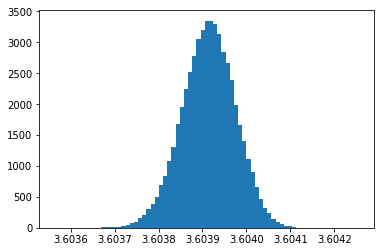

In [15]:
calc_prob(data, plot=True)

In [130]:
def run_lsp(time, flux, flux_err=None, data=None, true_period=None, ax=None, use_radians=False, legend=True, colours=None):
    """
    Determine the Lomb-Scargle Periodogram (nterms = 1-3) for the light curve data
    and plot the frequencies as well as the a folded light curve using

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    true_period : float
        The period on which to fold in hours
        
    

    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """


    from scipy.signal import argrelextrema

    #get l-s best period estimate
    from lombscargle import make_lsp
    from astropy.stats import LombScargle
    
    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
    
    lsp_periods = np.array([])

    fig, ax = plt.subplots(3,2, figsize=(10,10))
    
    for i in np.arange(3):
        freq, power = make_lsp(time, flux, flux_err, p_max=5.0, nterms=(i+1))

        # determine the indices of local power maxima
        best_idx = argrelextrema(power, np.greater)

        # sort these indices based on actual power value
        # reverse list so max is read first
        indices = np.argsort(power[best_idx[0]])[::-1]

        # sort our original indices based on the new
        # power-sorted indices
        best_idx = (best_idx[0]).T[indices]
        best_freqs = freq[best_idx].T

        new_freq = best_freqs[0]
        new_period = 1./new_freq
        new_log_period = np.log(1./new_freq)

        # plot all the frequencies
        ax[i][0].plot((1./freq)*24., power, color="black", alpha=0.7)
        ax[i][0].set_xlabel('Period (hrs)')
        ax[i][0].set_ylabel("Normalized Power")
        ax[i][0].set_title("nterms = %s" %(i+1))
        ax[i][0].vlines(new_period*24., 0, 1, colors='orange', linestyles='--',
                  label = 'Best fit : ' + str(round(new_period*24., 5)))
        if true_period != 0:
            ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
                  label = 'True fit : ' + str(true_period))
        ax[i][0].hist(masked_data[:,3], bins=50, alpha=0.5, density=True, label="Posterior")
        ax[i][0].set_xlim([0,24])
        ax[i][0].set_ylim(ymin=0)
        ax[i][0].legend()
        
        if true_period:
            ax[i][0].vlines(true_period, 0, 1, colors='blue', linestyles='--',
                            label = 'True fit : ' + str(true_period))

        plot_folded_lightcurve(time, flux, period=new_period, ax=ax[i][1])
        
        lsp_periods = np.append(lsp_periods, new_period*24.)

    #namestr=filename + "_plots"
    plt.tight_layout()
    #plt.savefig(namestr + "_lsp.pdf", format="pdf")

    return lsp_periods


In [6]:
def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None,
                      ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in days**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["black", "#33B3FF", "#FFB733"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period - np.floor((time-t0)/period)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="data")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="data")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period - np.floor(true_time/period)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="true light curve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1])
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1])

    if models:

        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period) - np.floor(m_time/period)
        print("mphase " + str(m_phase))
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)

        print("tdiff " + str(tdiff))
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]
        #if idx.size == 0:
        #    idx = np.array(0)

        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2])

                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2])

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Flux")
    period_hours = period*24.
    ax.set_title(r"period $P = %.3f$"%period_hours)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax


In [186]:
filename = "../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_40days.txt.hdf5"

In [192]:
with h5py.File(filename, "r") as f:
    data = f['chain'][:]
    time = f['time'][:]
    flux = f["flux"][:]
    flux_err = f['flux_err'][:]
    true_period = f.attrs['true_period']
    #burn_in = f.attrs["burn_in"]
    
    for item in f.attrs.keys():
        print(item + ":", f.attrs[item])
        
    #print(burn_in)
    
    

true_period: 0
walkers: 100
iterations: 10000
data_pts: 80
acceptance_fraction: [2.053e-01 1.862e-01 1.877e-01 1.794e-01 1.842e-01 2.184e-01 1.860e-01
 2.140e-01 2.169e-01 2.180e-02 1.881e-01 1.826e-01 1.929e-01 2.180e-01
 2.169e-01 2.213e-01 2.144e-01 2.056e-01 6.450e-02 1.654e-01 2.175e-01
 2.136e-01 1.862e-01 2.083e-01 1.000e-04 2.113e-01 1.825e-01 1.806e-01
 1.908e-01 1.873e-01 1.830e-01 1.821e-01 8.220e-02 2.155e-01 2.240e-01
 1.827e-01 7.420e-02 1.879e-01 1.824e-01 3.890e-02 1.921e-01 2.151e-01
 1.834e-01 2.082e-01 1.095e-01 1.815e-01 1.852e-01 1.814e-01 2.200e-01
 1.619e-01 3.170e-02 2.820e-01 2.125e-01 2.760e-01 2.166e-01 2.198e-01
 2.870e-01 2.190e-02 3.220e-02 2.152e-01 2.173e-01 8.700e-03 2.074e-01
 6.780e-02 2.141e-01 2.854e-01 2.888e-01 2.883e-01 2.091e-01 1.260e-02
 2.101e-01 2.143e-01 2.788e-01 2.160e-01 2.138e-01 2.758e-01 2.829e-01
 1.150e-02 1.112e-01 2.405e-01 1.262e-01 3.020e-02 2.113e-01 2.052e-01
 1.000e-04 2.774e-01 2.845e-01 2.157e-01 7.230e-02 2.951e-01 3.320e-

(100, 10000, 4)


3.6039269454112866


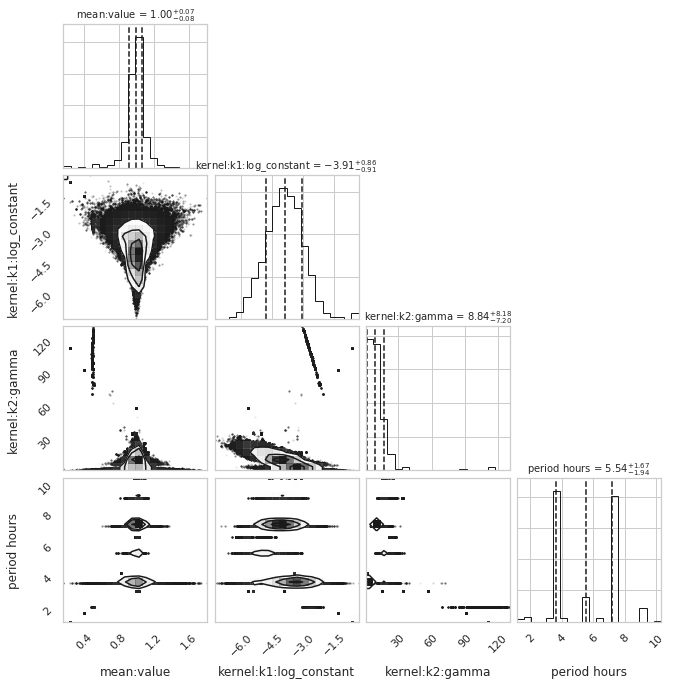

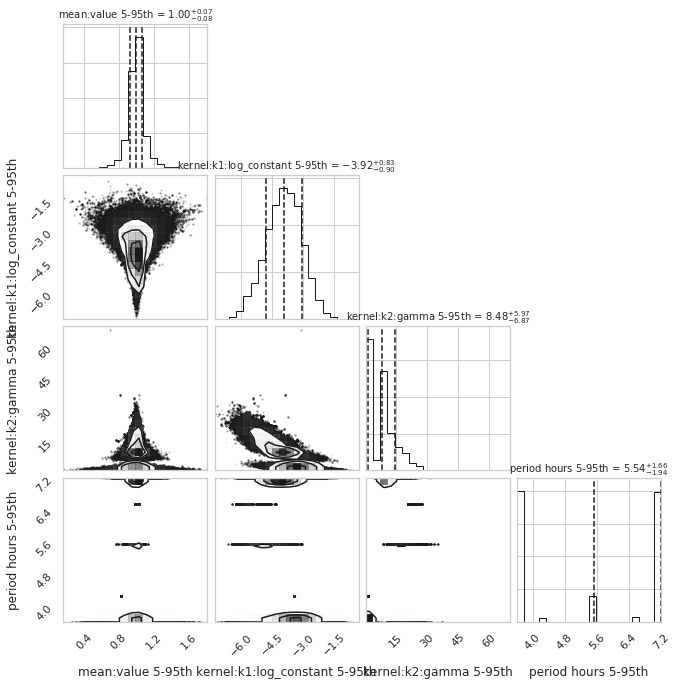

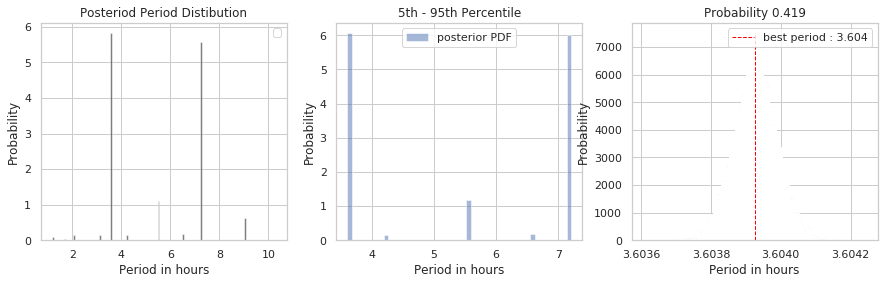

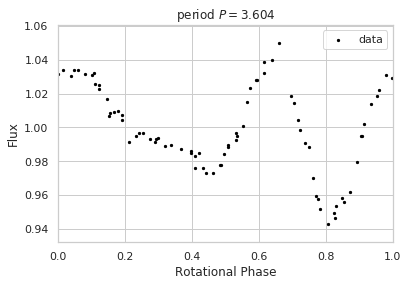

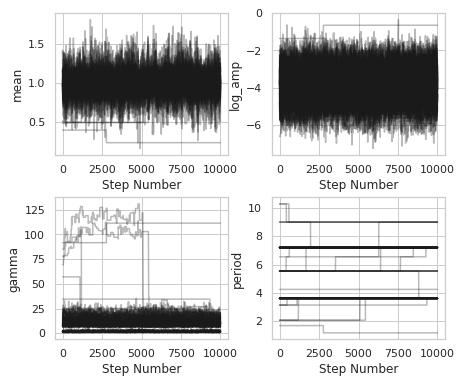

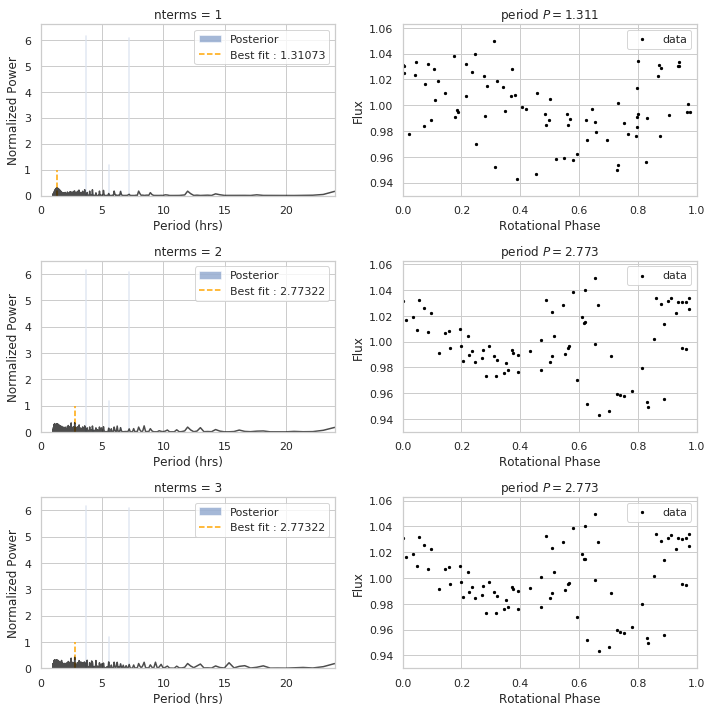

In [193]:
with h5py.File(filename, "r") as f:
    data = f['chain'][:]
    time = f['time'][:]
    flux = f["flux"][:]
    flux_err = f['flux_err'][:]
    true_period = f.attrs['true_period']
    
    print(data.shape)
    
    
    gp = set_kernel(time, flux, flux_err)
   
    data[:,:,3] = np.exp(data[:,:,3])*24.
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    
    plot_corner(data, f.attrs['walkers'], f.attrs['iterations'], gp)
    
    ax = plot_corner_5_95(data, f.attrs['walkers'], f.attrs['iterations'], gp)
    plt.savefig(filename + "_test.pdf", format="pdf")
    
    best_period = plot_posterior(data, true_period=true_period)
    
    ##folded lightcurve###
    plot_folded_lightcurve(time, flux, period=(best_period)/24.)
    plt.savefig(filename + "_test2.pdf", format="pdf")
    
    plot_trace(data, f.attrs['iterations'])
    
    run_lsp(time, flux, flux_err, data, true_period)
    
    
    #print(type(flat_data[:,3]))



In [194]:
files = list()
import glob, os
print(os.getcwd())
#os.chdir("../data/paper_plots/3200/ztf-lsst/")
for file in glob.glob("../data/paper_plots/3200/ztf-lsst/burn_in_10k/*.hdf5"):
    files.append(file)

/home/christina/CometGPs/notebooks


In [195]:
files

['../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_20days.txt.hdf5',
 '../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_10days.txt.hdf5',
 '../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_30days.txt.hdf5',
 '../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_50days.txt.hdf5',
 '../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_40days.txt.hdf5',
 '../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_60days.txt.hdf5']

In [196]:
x = np.sort(np.array(list(np.arange(10, 70, 10))*1000000))

../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_20days.txt.hdf5
(100, 10000, 4)
899985
[7.20670229 7.20670229 7.20670229 ... 9.00780545 9.00824052 9.00830936]
../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_10days.txt.hdf5
(100, 10000, 4)
899988
[3.60282887 3.60282887 3.60297396 ... 3.60374081 3.60374081 3.60374081]
../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_30days.txt.hdf5
(100, 10000, 4)
899983
[6.55218554 6.55218554 6.55218554 ... 9.00934359 9.00934359 9.00934359]
../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_50days.txt.hdf5
(100, 10000, 4)
899999
[9.01051873 9.01051873 9.01051873 ... 7.20843891 7.20843891 7.20841317]
../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_40days.txt.hdf5
(100, 10000, 4)
899989
[3.60385365 3.60385365 3.60387308 ... 3.60386577 3.60386577 3.60386

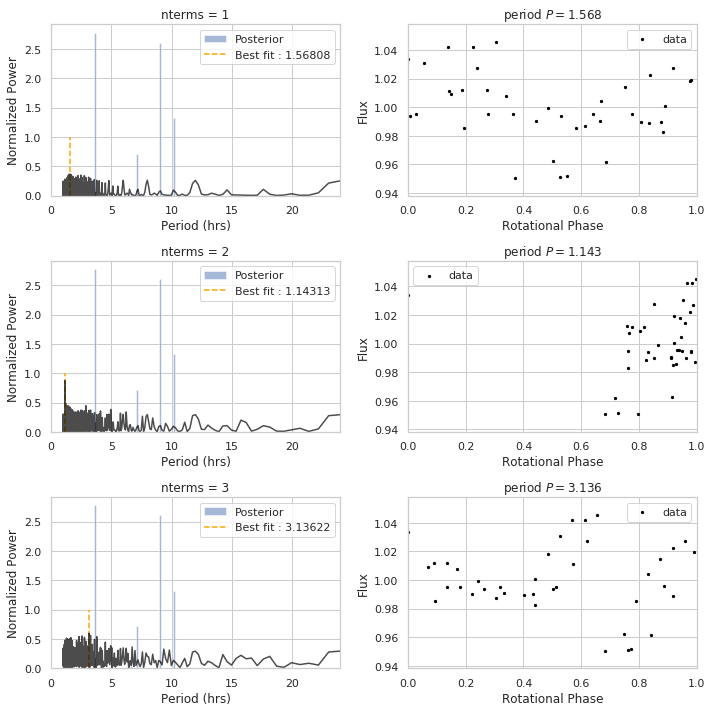

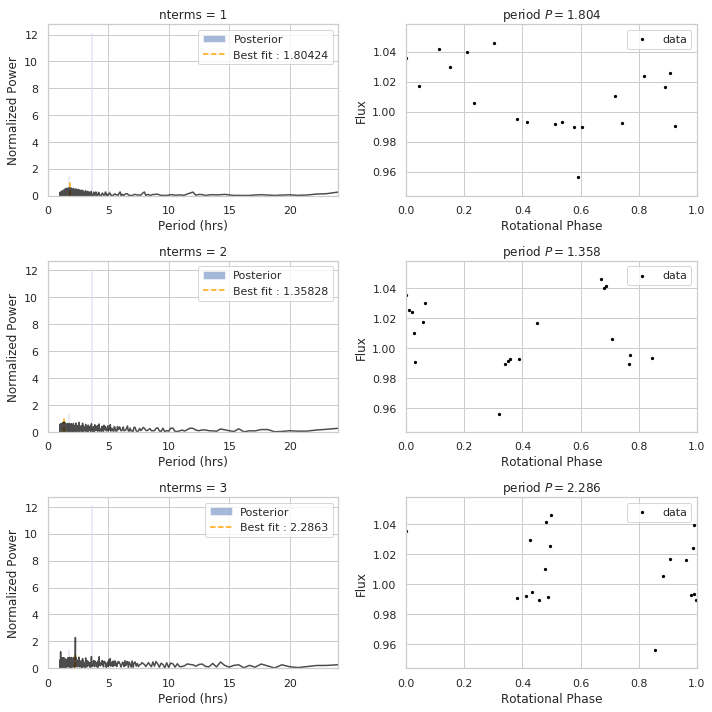

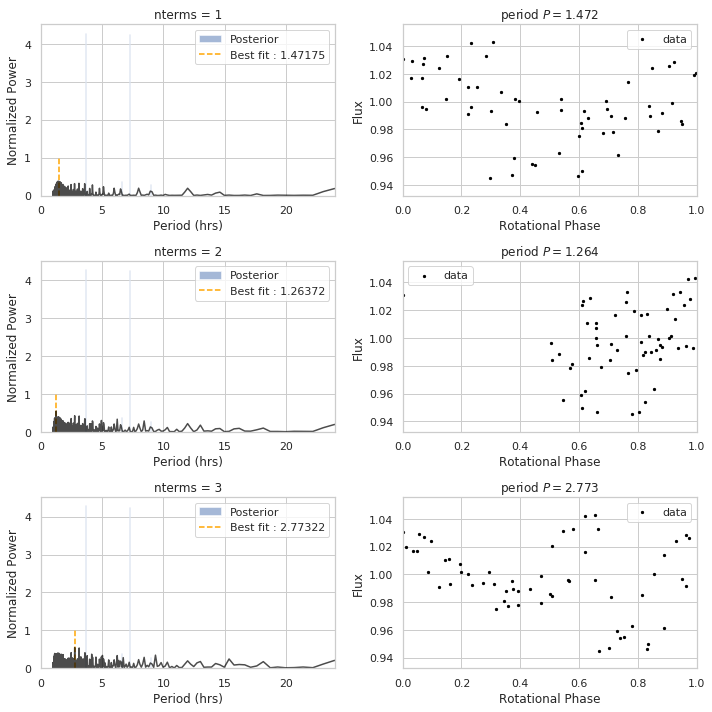

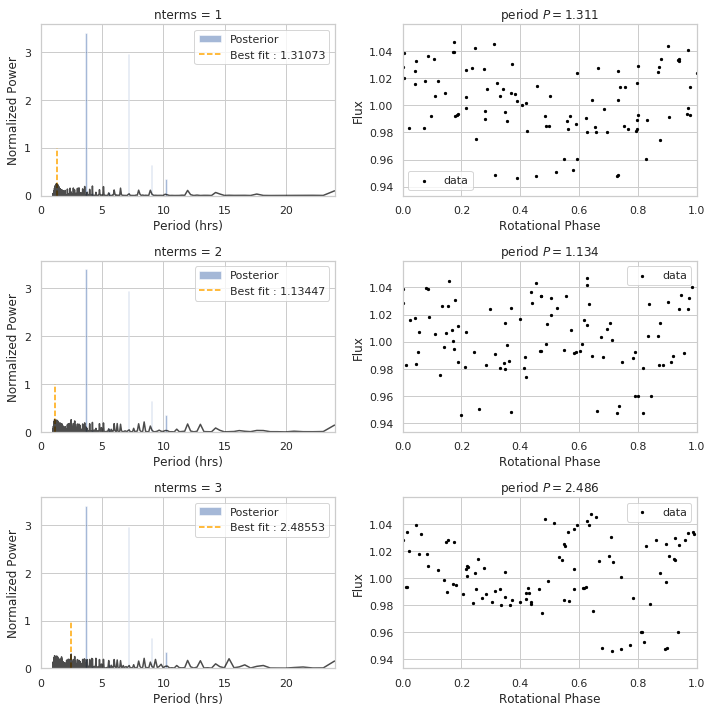

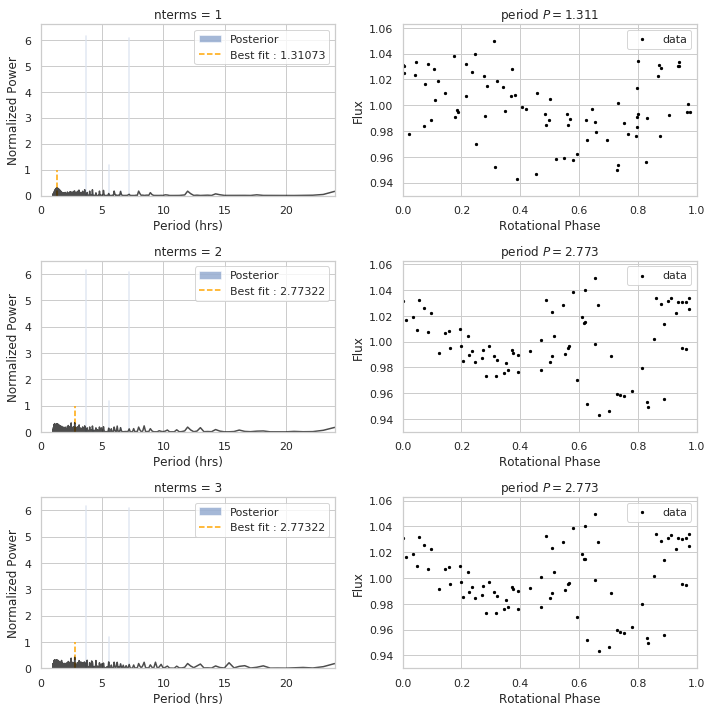

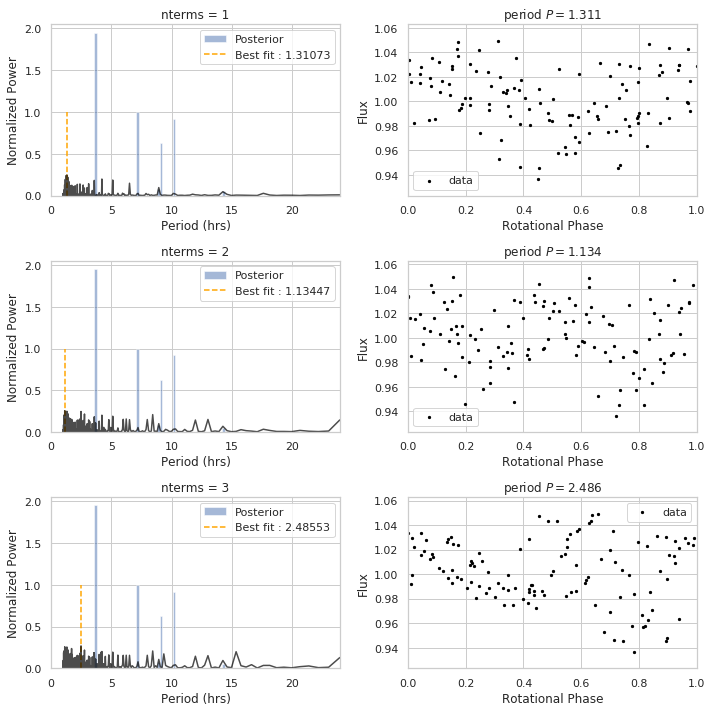

In [197]:
data_meta = np.array([])
x = np.array([])
lsp_period_all = np.array([])

for i in np.arange(len(files)):
    filename = files[i]
    print(filename)
    
    with h5py.File(filename, "r") as f:
        data = f['chain'][:]
        time = f['time'][:]
        flux = f["flux"][:]
        flux_err = f['flux_err'][:]
        true_period = f.attrs['true_period']
        data_pts = f.attrs["data_pts"]

        print(data.shape)


        gp = set_kernel(time, flux, flux_err)

        data[:,:,3] = np.exp(data[:,:,3])*24.
        lower, upper = np.percentile(data[:,:,3], [5,95])
        masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]
        flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    
        print(len(masked_data[:,3]))
        print(masked_data[:,3])
    #print((list(np.arange(data_pts, data_pts+1))))
    #print(list(np.arange(data_pts, data_pts+1))*len(masked_data[:,3]))
    
        lsp_period = run_lsp(time, flux, flux_err, data, true_period)
        
        lsp_period_all = np.append(lsp_period_all, lsp_period)
    
        x = np.append(x, np.array(list(np.arange(data_pts, data_pts+1))*len(masked_data[:,3])))
        data_meta = np.append(data_meta, masked_data[:,3])
        
    

In [198]:
lsp_period_all

array([1.56807532, 1.14313207, 3.13621964, 1.80423722, 1.35828347,
       2.2863008 , 1.47175421, 1.26371776, 2.77321713, 1.31072781,
       1.13447184, 2.48552898, 1.31072781, 2.77321713, 2.77321713,
       1.31072781, 1.13447184, 2.48552898])

In [199]:
n_terms = np.array(list(np.arange(1,4))*6)

In [200]:
n_terms

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

In [201]:
x_lsp = np.sort(np.array(list(np.arange(0, 6))*3))

In [202]:
df_lsp1 = pd.DataFrame(data = x_lsp, columns = ["data_pts"], dtype=int)
df_lsp2 = pd.DataFrame(data = lsp_period_all, columns = ["lsp_period"])
df_lsp3 = pd.DataFrame(data = n_terms, columns = ["n_terms"])

In [203]:
df_lsp12 = df_lsp1.join(df_lsp2)
df_lsp = df_lsp12.join(df_lsp3)

In [204]:
df_lsp

,data_pts,lsp_period,n_terms
0,0,1.568075,1
1,0,1.143132,2
2,0,3.136220,3
3,1,1.804237,1
4,1,1.358283,2
5,1,2.286301,3
6,2,1.471754,1
7,2,1.263718,2
8,2,2.773217,3
9,3,1.310728,1


In [205]:
df1 = pd.DataFrame(data = x, columns = ["data_pts"], dtype=int)
df2 = pd.DataFrame(data = data_meta, columns = ["period"])
df = df1.join(df2)

/home/christina/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-1, 6)

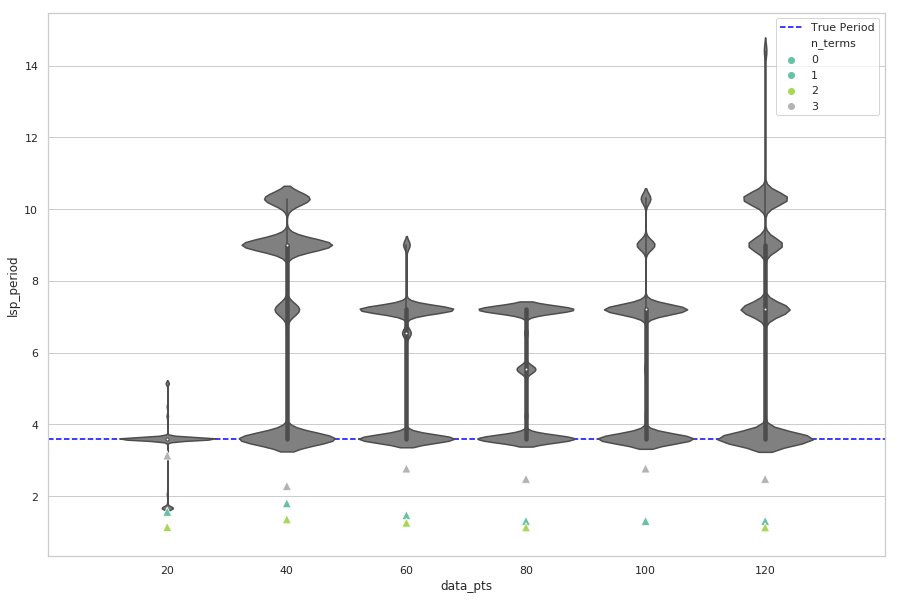

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
#sns.set(style="whitegrid")

ax.hlines(3.604, -1, 6, colors="blue", linestyles='dashed', label="True Period", zorder=1)
sns.violinplot(x = "data_pts", y = "period", data=df, scale="count", color="grey", ax=ax, zorder=2)
sns.scatterplot(x = "data_pts", y="lsp_period", hue="n_terms", data=df_lsp, s=80,
                marker="^", palette="Set2", zorder=3, ax=ax)

ax.set_xlim([-1,6])